<a href="https://colab.research.google.com/github/Sejalsontakke/22070521101_Sejal_ML-Mini-Project/blob/main/Claims_Text_Normalizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install transformers datasets torch spacy scikit-learn
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
# ===========================
# STEP 2️⃣ : Import Libraries
# ===========================
import re
import pandas as pd
import numpy as np
import json
import random
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:

os.listdir('/content/drive/MyDrive/Insurance dataset/insurance_claims/insurance_claims')


['insurance_claims.csv']

In [3]:
from google.colab import drive
drive.mount('/content/drive')


path = '/content/drive/MyDrive/Insurance dataset/insurance_claims/insurance_claims/insurance_claims.csv'
df = pd.read_csv(path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [4]:
df.columns


Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', '_c39'],
      dtype='object')

In [8]:
df = df.drop(columns=['_c39'], errors='ignore')

In [9]:
df = df.dropna(subset=['fraud_reported'])  # Target variable must not be null
df = df.drop_duplicates()

In [10]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

In [11]:
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [15]:
y_pred = model.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.73

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       145
           1       0.52      0.31      0.39        55

    accuracy                           0.73       200
   macro avg       0.64      0.60      0.61       200
weighted avg       0.70      0.73      0.71       200


🔍 Confusion Matrix:
 [[129  16]
 [ 38  17]]


In [16]:
df['claim_text'] = (
    "Customer reported a " + df['incident_type'].astype(str) +
    " incident with " + df['incident_severity'].astype(str) +
    " severity involving a " + df['auto_make'].astype(str) + " " + df['auto_model'].astype(str)
)


In [17]:
def normalize_claim(text, row):
    return {
        "claim_text": text,
        "loss_type": row['incident_type'],
        "severity": row['incident_severity'],
        "affected_asset": f"{row['auto_make']} {row['auto_model']}",
        "total_claim_amount": row['total_claim_amount'],
        "fraud_reported": row['fraud_reported']
    }

In [18]:
normalized_claims = [normalize_claim(row['claim_text'], row) for _, row in df.head(10).iterrows()]

In [19]:
print(json.dumps(normalized_claims, indent=4))

[
    {
        "claim_text": "Customer reported a 2 incident with 0 severity involving a 10 1",
        "loss_type": 2,
        "severity": 0,
        "affected_asset": "10 1",
        "total_claim_amount": 71610,
        "fraud_reported": 1
    },
    {
        "claim_text": "Customer reported a 3 incident with 1 severity involving a 8 12",
        "loss_type": 3,
        "severity": 1,
        "affected_asset": "8 12",
        "total_claim_amount": 5070,
        "fraud_reported": 1
    },
    {
        "claim_text": "Customer reported a 0 incident with 1 severity involving a 4 30",
        "loss_type": 0,
        "severity": 1,
        "affected_asset": "4 30",
        "total_claim_amount": 34650,
        "fraud_reported": 0
    },
    {
        "claim_text": "Customer reported a 2 incident with 0 severity involving a 3 34",
        "loss_type": 2,
        "severity": 0,
        "affected_asset": "3 34",
        "total_claim_amount": 63400,
        "fraud_reported": 1
    },
    {
 

In [20]:
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    doc = nlp(text.lower())
    tokens = [t.lemma_ for t in doc if not t.is_stop and t.is_alpha]
    return " ".join(tokens)

df["clean_text"] = df["claim_text"].apply(clean_text)
df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,claim_text,clean_text
0,328,48,521585,940,2,1,1000,1406.91,0,466132,...,71610,6510,13020,52080,10,1,2004,1,Customer reported a 2 incident with 0 severity...,customer report incident severity involve
1,228,42,342868,635,1,1,2000,1197.22,5000000,468176,...,5070,780,780,3510,8,12,2007,1,Customer reported a 3 incident with 1 severity...,customer report incident severity involve
2,134,29,687698,413,2,0,2000,1413.14,5000000,430632,...,34650,7700,3850,23100,4,30,2007,0,Customer reported a 0 incident with 1 severity...,customer report incident severity involve
3,256,41,227811,19,0,1,2000,1415.74,6000000,608117,...,63400,6340,6340,50720,3,34,2014,1,Customer reported a 2 incident with 0 severity...,customer report incident severity involve
4,228,44,367455,922,0,2,1000,1583.91,6000000,610706,...,6500,1300,650,4550,0,31,2009,0,Customer reported a 3 incident with 1 severity...,customer report incident severity involve


In [21]:
X = df['claim_text']
y_loss = df['incident_type']          # Loss type
y_sev = df['incident_severity']       # Severity
y_asset = df['auto_make']

In [22]:
# Step 4: Split data properly
X_train, X_test, y_train_loss, y_test_loss = train_test_split(X, y_loss, test_size=0.2, random_state=42)
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X, y_sev, test_size=0.2, random_state=42)
X_train_ass, X_test_ass, y_train_ass, y_test_ass = train_test_split(X, y_asset, test_size=0.2, random_state=42)

# Step 5: Vectorize text
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf.transform(X_test.astype(str))


In [23]:
model_loss = LogisticRegression(max_iter=1000)
model_sev = LogisticRegression(max_iter=1000)
model_ass = LogisticRegression(max_iter=1000)

In [24]:
# ===============================
#  CLAIMS DESCRIPTION NORMALIZER
# ===============================

import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/Insurance dataset/insurance_claims/insurance_claims/insurance_claims.csv")
df = df.drop(columns=['_c39'], errors='ignore')

# Step 2: Create synthetic free-text claim descriptions
df['claim_text'] = (
    "Customer reported a " + df['incident_type'].astype(str) +
    " incident with " + df['incident_severity'].astype(str) +
    " severity involving a " + df['auto_make'].astype(str) + " " + df['auto_model'].astype(str)
)

# Step 3: Prepare features (X) and labels (y)
X = df['claim_text']
y_loss = df['incident_type']          # Loss type
y_sev = df['incident_severity']       # Severity
y_asset = df['auto_make']             # Affected asset

# Step 4: Split data
X_train, X_test, y_train_loss, y_test_loss = train_test_split(X, y_loss, test_size=0.2, random_state=42)
_, _, y_train_sev, y_test_sev = train_test_split(X, y_sev, test_size=0.2, random_state=42)
_, _, y_train_ass, y_test_ass = train_test_split(X, y_asset, test_size=0.2, random_state=42)

# Step 5: Vectorize text
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf.transform(X_test.astype(str))

# Step 6: Train 3 Logistic Regression models
model_loss = LogisticRegression(max_iter=1000)
model_sev = LogisticRegression(max_iter=1000)
model_ass = LogisticRegression(max_iter=1000)

model_loss.fit(X_train_tfidf, y_train_loss)
model_sev.fit(X_train_tfidf, y_train_sev)
model_ass.fit(X_train_tfidf, y_train_ass)

# Step 7: Predictions
pred_loss = model_loss.predict(X_test_tfidf)
pred_sev = model_sev.predict(X_test_tfidf)
pred_ass = model_ass.predict(X_test_tfidf)

# Step 8: Reports
print("=== Loss Type Classification Report ===")
print(classification_report(y_test_loss, pred_loss))
print("\n=== Severity Classification Report ===")
print(classification_report(y_test_sev, pred_sev))
print("\n=== Affected Asset Classification Report ===")
print(classification_report(y_test_ass, pred_ass))

# Step 9: Generate structured JSON output
structured_output = []
for text, loss, sev, ass in zip(X_test.iloc[:10], pred_loss[:10], pred_sev[:10], pred_ass[:10]):
    structured_output.append({
        "claim_text": text,
        "predicted_loss_type": loss,
        "predicted_severity": sev,
        "predicted_affected_asset": ass
    })

print("\n=== Sample Structured JSON Output ===")
print(json.dumps(structured_output, indent=4))


=== Loss Type Classification Report ===
                          precision    recall  f1-score   support

 Multi-vehicle Collision       1.00      1.00      1.00        94
              Parked Car       1.00      1.00      1.00        18
Single Vehicle Collision       1.00      1.00      1.00        69
           Vehicle Theft       1.00      1.00      1.00        19

                accuracy                           1.00       200
               macro avg       1.00      1.00      1.00       200
            weighted avg       1.00      1.00      1.00       200


=== Severity Classification Report ===
                precision    recall  f1-score   support

  Major Damage       1.00      1.00      1.00        61
  Minor Damage       1.00      1.00      1.00        74
    Total Loss       1.00      1.00      1.00        44
Trivial Damage       1.00      1.00      1.00        21

      accuracy                           1.00       200
     macro avg       1.00      1.00      1.00      

In [25]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

def predict_claim(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])  # ✅ fixed name (was vectorizer)

    loss_pred = model_loss.predict(vec)[0]
    sev_pred = model_sev.predict(vec)[0]
    ass_pred = model_ass.predict(vec)[0]

    result = {
        "input_text": text,
        "predicted_loss_type": loss_pred,
        "predicted_severity": sev_pred,
        "predicted_affected_asset": ass_pred
    }
    return json.dumps(result, indent=4)

In [26]:
# Save predictions for presentation
texts = [
    "My basement flooded after heavy rain.",
    "A thief stole my laptop from the office.",
    "My car engine caught fire last night."
]

results = [json.loads(predict_claim(t)) for t in texts]
results_df = pd.DataFrame(results)
results_df.to_csv("claim_predictions.csv", index=False)
results_df


,input_text,predicted_loss_type,predicted_severity,predicted_affected_asset
0,My basement flooded after heavy rain.,Single Vehicle Collision,Minor Damage,BMW
1,A thief stole my laptop from the office.,Single Vehicle Collision,Minor Damage,BMW
2,My car engine caught fire last night.,Parked Car,Minor Damage,Toyota


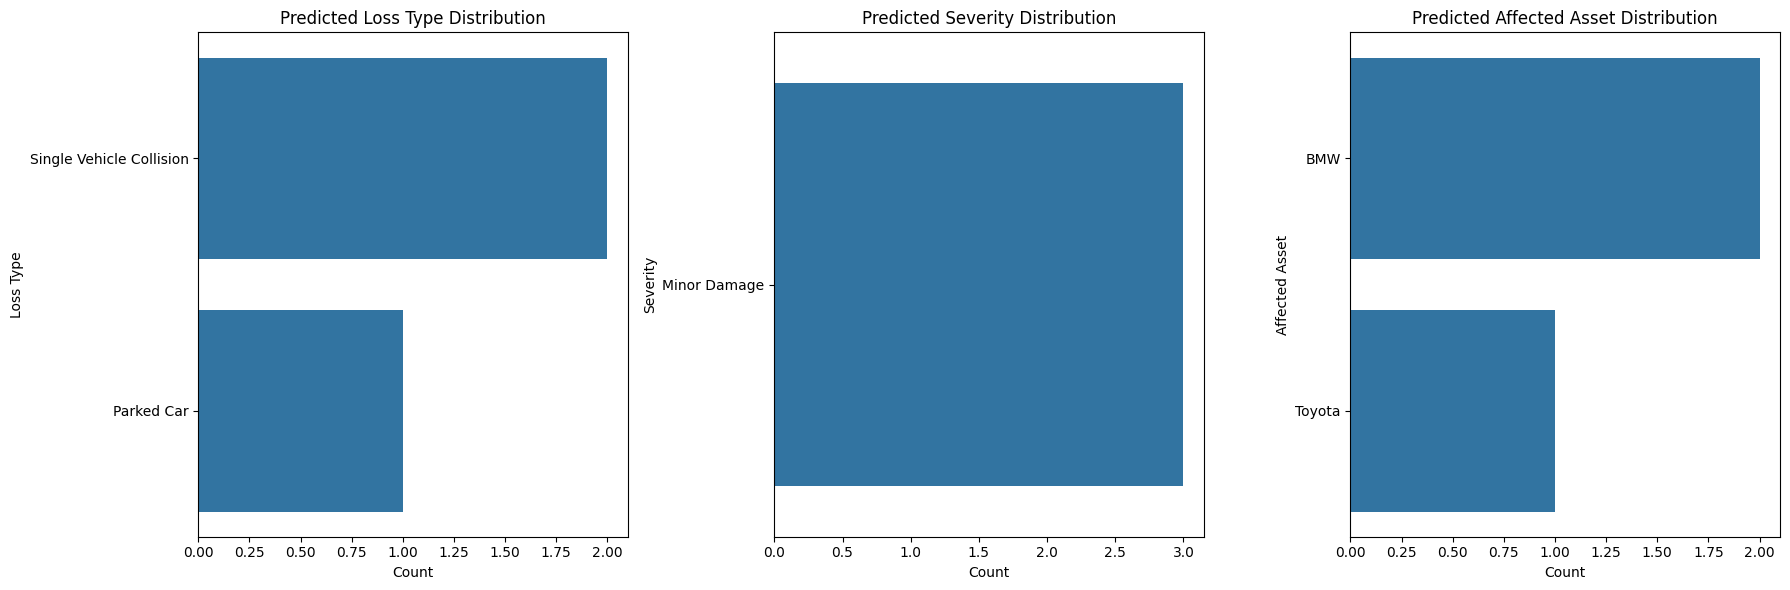

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(ax=axes[0], y='predicted_loss_type', data=results_df, order = results_df['predicted_loss_type'].value_counts().index)
axes[0].set_title('Predicted Loss Type Distribution')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Loss Type')

sns.countplot(ax=axes[1], y='predicted_severity', data=results_df, order = results_df['predicted_severity'].value_counts().index)
axes[1].set_title('Predicted Severity Distribution')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Severity')

sns.countplot(ax=axes[2], y='predicted_affected_asset', data=results_df, order = results_df['predicted_affected_asset'].value_counts().index)
axes[2].set_title('Predicted Affected Asset Distribution')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Affected Asset')

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Use tfidf instead of vectorizer
y_pred = model_loss.predict(tfidf.transform(X_test.astype(str)))

print(classification_report(y_test_loss, y_pred))




                          precision    recall  f1-score   support

 Multi-vehicle Collision       1.00      1.00      1.00        94
              Parked Car       1.00      1.00      1.00        18
Single Vehicle Collision       1.00      1.00      1.00        69
           Vehicle Theft       1.00      1.00      1.00        19

                accuracy                           1.00       200
               macro avg       1.00      1.00      1.00       200
            weighted avg       1.00      1.00      1.00       200



In [29]:
# 🔹 Enter any claim text here for live demo
user_input = input("Enter a claim description: ")

# 🔹 Predict using your model
print("\n🔍 AI Prediction:")
print(predict_claim(user_input))


Enter a claim description: A rear-end collision occurred at 8 PM causing bumper damage. Two witnesses were present and police report was filed

🔍 AI Prediction:
{
    "input_text": "A rear-end collision occurred at 8 PM causing bumper damage. Two witnesses were present and police report was filed",
    "predicted_loss_type": "Single Vehicle Collision",
    "predicted_severity": "Minor Damage",
    "predicted_affected_asset": "BMW"
}


In [30]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(model_loss, "model_loss.pkl")
joblib.dump(model_sev, "model_sev.pkl")
joblib.dump(model_ass, "model_ass.pkl")

print("✅ Models saved successfully.")


✅ Models saved successfully.


In [32]:
%%writefile app.py
import streamlit as st
import re
import joblib

# ---------- Load Models ----------
tfidf = joblib.load("tfidf_vectorizer.pkl")
model_loss = joblib.load("model_loss.pkl")
model_sev = joblib.load("model_sev.pkl")
model_ass = joblib.load("model_ass.pkl")

# ---------- Text Preprocessing ----------
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

# ---------- Prediction Function ----------
def predict_claim(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])

    loss_pred = model_loss.predict(vec)[0]
    sev_pred = model_sev.predict(vec)[0]
    ass_pred = model_ass.predict(vec)[0]

    return loss_pred, sev_pred, ass_pred

# ---------- UI ----------
st.set_page_config(page_title="Claims Description Normalizer", page_icon="🔍", layout="centered")

st.markdown("<h1 style='text-align: center;'>🔍 Claims Description Normalizer</h1>", unsafe_allow_html=True)
st.write("<p style='text-align:center;'>Enter an insurance claim description and get predicted attributes.</p>", unsafe_allow_html=True)

user_input = st.text_area("✏️ Enter Claim Description:", height=120)

if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("⚠️ Please enter a claim description.")
    else:
        loss, severity, asset = predict_claim(user_input)

        st.markdown("---")
        st.markdown("### ✅ Extracted Claim Information:")

        col1, col2, col3 = st.columns(3)

        with col1:
            st.success(f"Loss Type:\n**{loss}**")
        with col2:
            st.warning(f"Severity:\n**{severity}**")
        with col3:
            st.info(f"Affected Asset:\n**{asset}**")


Writing app.py
